# Integration and reference mapping with multigrate

In this notebook, we demonstrate how to use Multigrate with scArches: we build a trimodal reference atlas with Multigrate by integrating CITE-seq and multiome data, and map unimodal as well as multimodal queries onto the reference. We use publically available datasets from NeurIPS 2021 workshop https://openproblems.bio/neurips_2021/.

In [1]:
import scarches as sca
import scanpy as sc
import anndata as ad
import numpy as np
import muon
import gdown
import json

import warnings
warnings.filterwarnings("ignore")

sc.set_figure_params(figsize=(4, 4), fontsize=8)

 captum (see https://github.com/pytorch/captum).
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scarches/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scarches/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Data preprocessing
First, we download the datasets and split them into AnnData objects corresponding to individual modalities: gene expression (RNA) and protein abundance (ADT) for CITE-seq, and gene expression (RNA) and chromatin opennes (ATAC) for multiome.

In [2]:
# download
!wget 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz'
!wget 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad.gz'
# unzip
!gzip -d GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz
!gzip -d GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad.gz

--2022-11-24 18:09:53--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz
           => 'GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz'
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 165.112.9.229, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.228|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE194nnn/GSE194122/suppl ... done.
==> SIZE GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz ... 615842052
==> PASV ... done.    ==> RETR GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz ... done.
Length: 615842052 (587M) (unauthoritative)

100%[======================================>] 615,842,052 10.2MB/s   in 75s    

2022-11-24 18:11:10 (7.81 MB/s) - 'GSE194122_openproblems_neurips2021_cite_BMMC_processed

In [3]:
cite = sc.read('GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad')
cite

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [4]:
rna_cite = cite[:, cite.var['feature_types'] == 'GEX'].copy()
adt = cite[:, cite.var['feature_types'] == 'ADT'].copy()
rna_cite.shape, adt.shape

((90261, 13953), (90261, 134))

In [5]:
multiome = sc.read('GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')
multiome

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [6]:
rna_multiome = multiome[:, multiome.var['feature_types'] == 'GEX'].copy()
atac = multiome[:, multiome.var['feature_types'] == 'ATAC'].copy()
rna_multiome.shape, atac.shape

((69249, 13431), (69249, 116490))

### RNA preprocessing

Multigrate model can work with raw counts modelled with negative binomial (NB loss) distribution or normalized counts modelled with Gaussian (MSE loss). We also subset the genes to the top 4000 highly variable genes to speed up calculations. Hence, we need concatenate both RNA objects, normalize the counts per cell, subset the genes to the batch-aware highly variable genes and split the object back into two, correpsonding to the two experiments. Note that in this notebook we will work with raw counts for RNA-seq data but we need normalized counts to select highly variable genes.

In [7]:
# concat
rna = ad.concat([rna_cite, rna_multiome])
# normalize
rna.X = rna.layers['counts'].copy()
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
# subset to hvg
sc.pp.highly_variable_genes(rna, n_top_genes=4000, batch_key='Samplename')
rna = rna[:, rna.var.highly_variable].copy()
# split again
rna_cite = rna[rna.obs['Modality'] == 'cite'].copy()
rna_multiome = rna[rna.obs['Modality'] == 'multiome'].copy()
rna_multiome.shape, rna_cite.shape

((69249, 4000), (90261, 4000))

### ADT preprocessing

For ADT modality, Multigrate requires normalized counts, so we normalize the raw counts using the CLR transformation.

In [8]:
adt.X = adt.layers['counts'].copy()
muon.prot.pp.clr(adt)
adt.layers['clr'] = adt.X.copy()
adt

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'clr'

### ATAC preprocessing

We recommend log-normalized or tf-idf transformed ATAC counts with Multigrate. Similarly to RNA-seq, we subset the features to the top 20,000 highly variable features to speed up integration.

In [9]:
atac.X = atac.layers['counts'].copy()
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)
atac.layers['log-norm'] = atac.X.copy()
atac

AnnData object with n_obs × n_vars = 69249 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'log-norm'

In [10]:
sc.pp.highly_variable_genes(atac, n_top_genes=20000, batch_key='batch')
atac = atac[:, atac.var.highly_variable].copy()
atac

AnnData object with n_obs × n_vars = 69249 × 20000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'log-norm'

### Add harmonized cell type labels

Since the cell type annotations are not harmonized in the original data, we rename some of the cell types so they align between CITE-seq and multiome datasets.

In [11]:
gdown.download("https://drive.google.com/u/1/uc?id=1D54P3jURwkdA3goPqYuby0qx6RzKqcP2")

Downloading...
From: https://drive.google.com/u/1/uc?id=1D54P3jURwkdA3goPqYuby0qx6RzKqcP2
To: /lustre/groups/ml01/workspace/anastasia.litinetskaya/code/scarches/notebooks/cellttype_harmonize.json
100%|██████████| 4.77k/4.77k [00:00<00:00, 3.71MB/s]


'cellttype_harmonize.json'

In [12]:
with open('cellttype_harmonize.json', 'r') as f:
    harmonized_celltypes = json.load(f)
harmonized_celltypes.keys()

dict_keys(['cite_ct_l1_map', 'cite_ct_l2_map', 'multi_ct_l1_map', 'multi_ct_l2_map'])

In [13]:
rna_multiome.obs['l1_cell_type'] = rna_multiome.obs['cell_type'].map(harmonized_celltypes['multi_ct_l1_map'])
rna_multiome.obs['l2_cell_type'] = rna_multiome.obs['cell_type'].map(harmonized_celltypes['multi_ct_l2_map'])

atac.obs['l1_cell_type'] = atac.obs['cell_type'].map(harmonized_celltypes['multi_ct_l1_map'])
atac.obs['l2_cell_type'] = atac.obs['cell_type'].map(harmonized_celltypes['multi_ct_l2_map'])

rna_cite.obs['l1_cell_type'] = rna_cite.obs['cell_type'].map(harmonized_celltypes['cite_ct_l1_map'])
rna_cite.obs['l2_cell_type'] = rna_cite.obs['cell_type'].map(harmonized_celltypes['cite_ct_l2_map'])

adt.obs['l1_cell_type'] = adt.obs['cell_type'].map(harmonized_celltypes['cite_ct_l1_map'])
adt.obs['l2_cell_type'] = adt.obs['cell_type'].map(harmonized_celltypes['cite_ct_l2_map'])

### Subset to reference and query

We split the dataset into a reference (3 batches) and a query (2 batches).

In [14]:
# define the reference and the query batches
cite_reference_batches = ['s1d1', 's1d2', 's1d3']
multiome_reference_batches = ['s1d1', 's1d2', 's1d3']
cite_query_batches = ['s2d1', 's2d4']
multiome_query_batches = ['s2d1', 's2d4']
# query
rna_multiome_query = rna_multiome[rna_multiome.obs['batch'].isin(multiome_query_batches)].copy()
atac_query = atac[atac.obs['batch'].isin(multiome_query_batches)].copy()
rna_cite_query = rna_cite[rna_cite.obs['batch'].isin(cite_query_batches)].copy()
adt_query = adt[adt.obs['batch'].isin(cite_query_batches)].copy()
# reference
rna_multiome = rna_multiome[rna_multiome.obs['batch'].isin(multiome_reference_batches)].copy()
atac = atac[atac.obs['batch'].isin(multiome_reference_batches)].copy()
rna_cite = rna_cite[rna_cite.obs['batch'].isin(cite_reference_batches)].copy()
adt = adt[adt.obs['batch'].isin(cite_reference_batches)].copy()

## Prep the input AnnData object

First, we need to organize AnnData objects correspoding to different datasets and modalities into 1 AnnData object. In this example we have 1 CITE-seq dataset and 1 multiome dataset, hence we input 4 anndata objects: 2 (RNA and ADT) for CITE-seq and 2 (RNA and ATAC) for multiome.

Notes:
- paired datasets have to have the same .obs_names, i.e. index;
- each sublist in `adatas`, `layers` parameters corresponds to one modality. If you have multiple objects per modality, append them to the corresponding list;
- objects in each sublist have to have the same set of features: if you want to integrate multiple RNA objects, we recommend first concatenating full objects and then subsetting to 2000-4000 highly variable genes; for ADT modality, we take the intersection of available proteins (double check the naming conventions, as that can vary a lot from one dataset to another, so `.var_names` can have almost no intersection but if you align the protein names, then there is an overlap);
- `layers` parameter specifies which layer the model should take the counts from. If `None`, then defaults to `.X`. The distribution of the input data should be the same within a modality, e.g. here we use raw counts for RNA-seq modality.

In [15]:
adata = sca.models.organize_multiome_anndatas(
    adatas = [[rna_cite, rna_multiome], [None, atac], [adt, None]],    # a list of anndata objects per modality, RNA-seq always goes first
    layers = [['counts', 'counts'], [None, 'log-norm'], ['clr', None]], # if need to use data from .layers, if None use .X
)
adata

AnnData object with n_obs × n_vars = 33554 × 24134
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes'
    var: 'modality'
    uns: 'modality_lengths'
    layers: 'counts'

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we recommend using NB loss (or ZINB), thus we need to calculate `size_factors` by specifying the `rna_indices_end` parameter. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified. Here we also want to correct for batch effects, so we specify  `Samplename` as a categorical covariate. Since we want to integrate 2 different modalities, we need to register `Modality` as an additional covariate.

In [16]:
sca.models.MultiVAE.setup_anndata(
    adata,
    categorical_covariate_keys=['Modality', 'Samplename'],
    rna_indices_end=4000,
)

## Initialize the model

Next, we initialize the model. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. For ADT we use CLR-normalized counts and MSE loss. We need to specify `mmd='marginal'` and set the coeficient to the integration loss if we want to later map unimodal data onto this reference.

In [17]:
model = sca.models.MultiVAE(
    adata, 
    losses=['nb', 'mse', 'mse'],
    loss_coefs={'kl': 1e-1,
               'integ': 3000,
               },
    integrate_on='Modality',
    mmd='marginal',
)

## Train the model

You can specify the number of epochs by setting `max_epochs` parameter, default is 200. The default batch size is set to `batch_size = 256`, adjust if needed.

In [18]:
model.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [27:27<00:00,  8.04s/it, loss=1.88e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [27:28<00:00,  8.24s/it, loss=1.88e+03, v_num=1]


## Inference

Next, we get the latent representation for all the cells and save them in `.obsm['latent_ref']` as `.obsm['latent']` will be later overwritten when we fine-tune the model on the query.

In [19]:
model.get_latent_representation()
adata.obsm['latent_ref'] = adata.obsm['latent'].copy()
adata

AnnData object with n_obs × n_vars = 33554 × 24134
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'latent', 'latent_ref'
    layers: 'counts'

Visualize the integrated latent embedding.

In [20]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

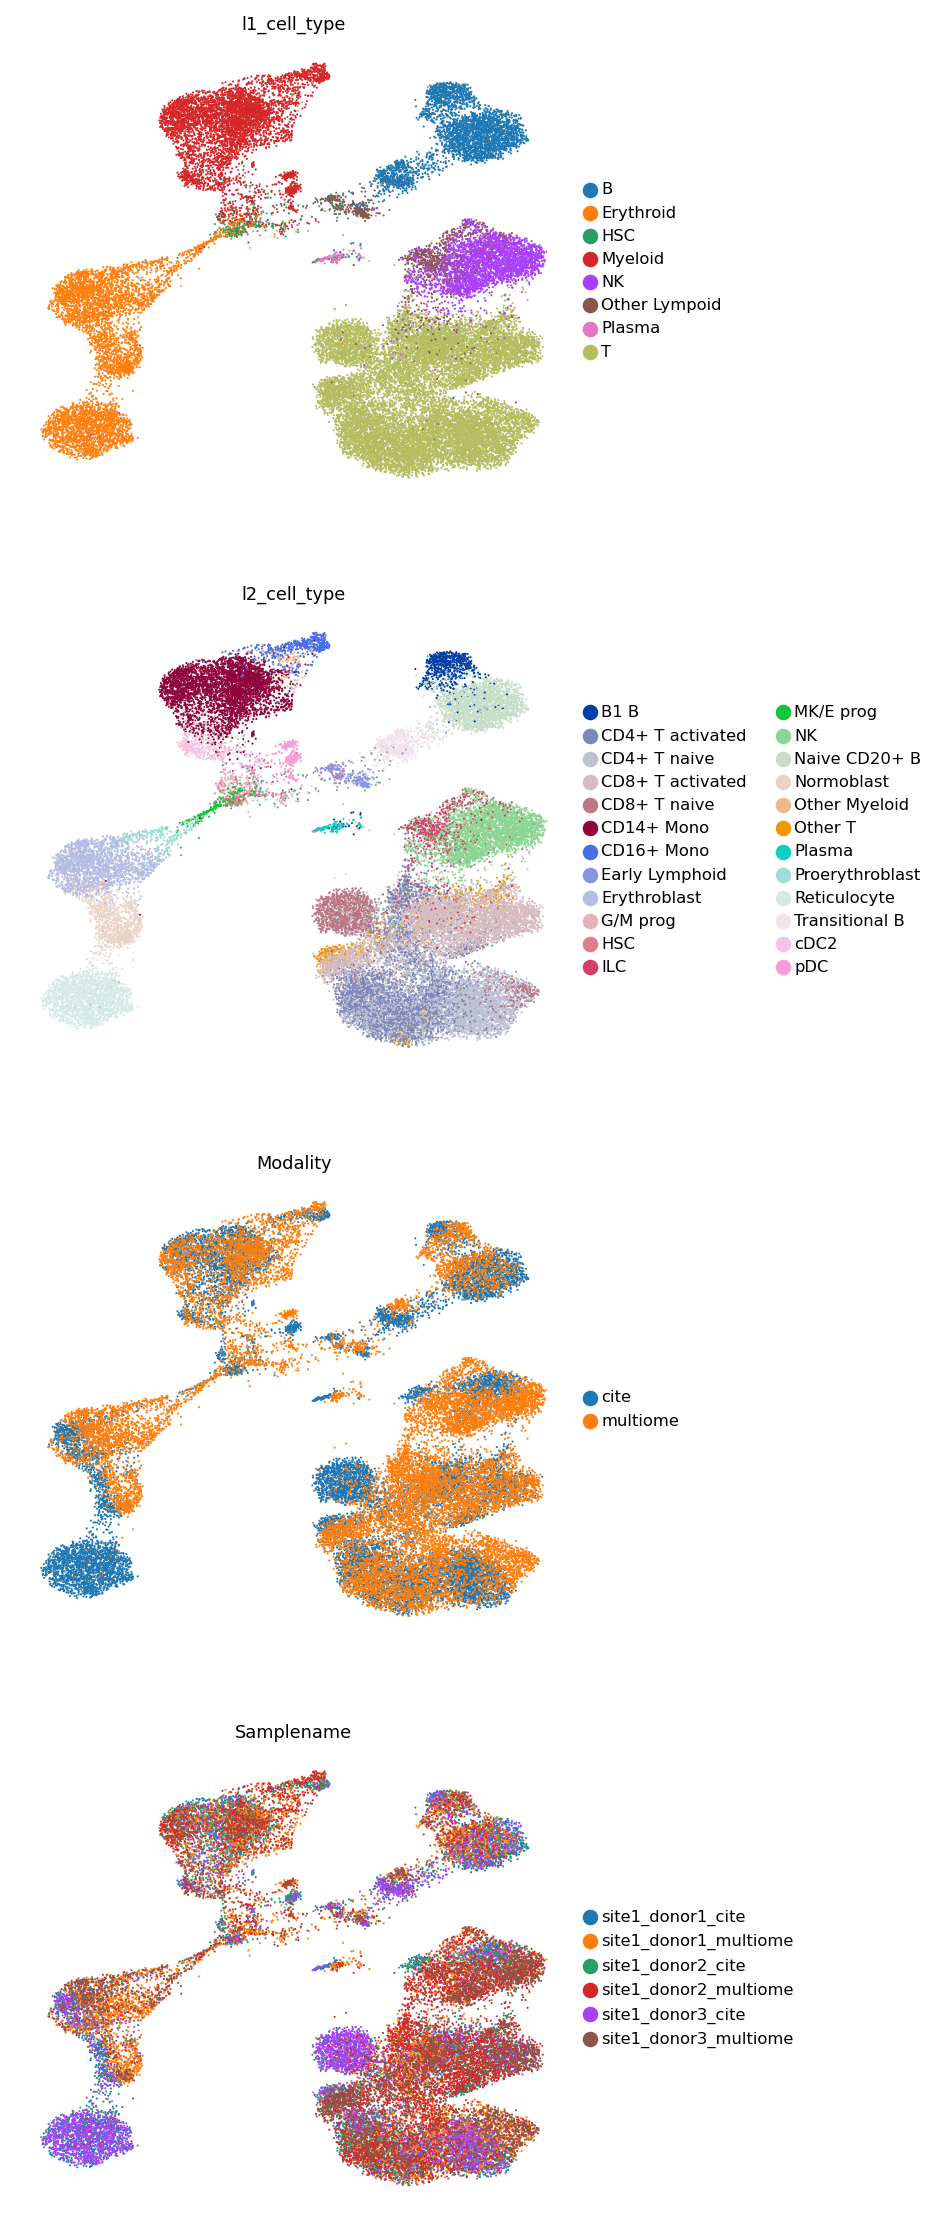

In [21]:
sc.pl.umap(adata, color=['l1_cell_type', 'l2_cell_type', 'Modality', 'Samplename'], frameon=False, ncols=1)

## Query mapping

We repeat the same steps for the setting up the query as for the reference before.

In [22]:
query = sca.models.organize_multiome_anndatas(
    adatas = [[rna_cite_query, rna_multiome_query], [None, atac_query], [adt_query, None]],
    layers = [['counts', 'counts'], [None, 'log-norm'], ['clr', None]],
)

In [23]:
sca.models.MultiVAE.setup_anndata(
    query,
    categorical_covariate_keys=['Modality', 'Samplename'],
    rna_indices_end=4000,
)

We imitate a unimodal RNA-seq query by masking with zeros the ADT part of one CITE-seq batch and RNA part of one multiome batch.

In [24]:
idx_atac_query = query.obs['Samplename'] == 'site2_donor4_multiome'
idx_scrna_query = query.obs['Samplename'] == 'site2_donor1_cite'

idx_mutiome_query = query.obs['Samplename'] == 'site2_donor1_multiome'
idx_cite_query = query.obs['Samplename'] == 'site2_donor4_cite'

np.sum(idx_atac_query), np.sum(idx_scrna_query), np.sum(idx_mutiome_query), np.sum(idx_cite_query)

(6111, 10465, 4220, 5584)

In [25]:
query[idx_atac_query, :4000].X = 0
query[idx_scrna_query, 4000:].X = 0

We update the model by adding new weights to the new batches in the query and fine-tune those weights.

In [26]:
q_model = sca.models.MultiVAE.load_query_data(query, model)

In [27]:
q_model.train(weight_decay=0)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [20:35<00:00,  6.21s/it, loss=1.38e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [20:35<00:00,  6.18s/it, loss=1.38e+03, v_num=1]


We obtain the latent representation for the query and the reference from the updated model. Note that the representation of the reference is the same as before up to sampling noise.

In [28]:
q_model.get_latent_representation(adata=query)
q_model.get_latent_representation(adata=adata)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [29]:
adata.obs['reference'] = 'reference'
query.obs['reference'] = 'query'

adata.obs['type_of_query'] = 'reference'
query.obs.loc[idx_atac_query, 'type_of_query'] = 'ATAC query'
query.obs.loc[idx_scrna_query, 'type_of_query'] = 'scRNA query'
query.obs.loc[idx_mutiome_query, 'type_of_query'] = 'multiome query'
query.obs.loc[idx_cite_query, 'type_of_query'] = 'CITE-seq query'

Finally, we concatentae the reference and the query, and visualize both on a UMAP.

In [30]:
adata_both = ad.concat([adata, query])

In [31]:
sc.pp.neighbors(adata_both, use_rep='latent')
sc.tl.umap(adata_both)

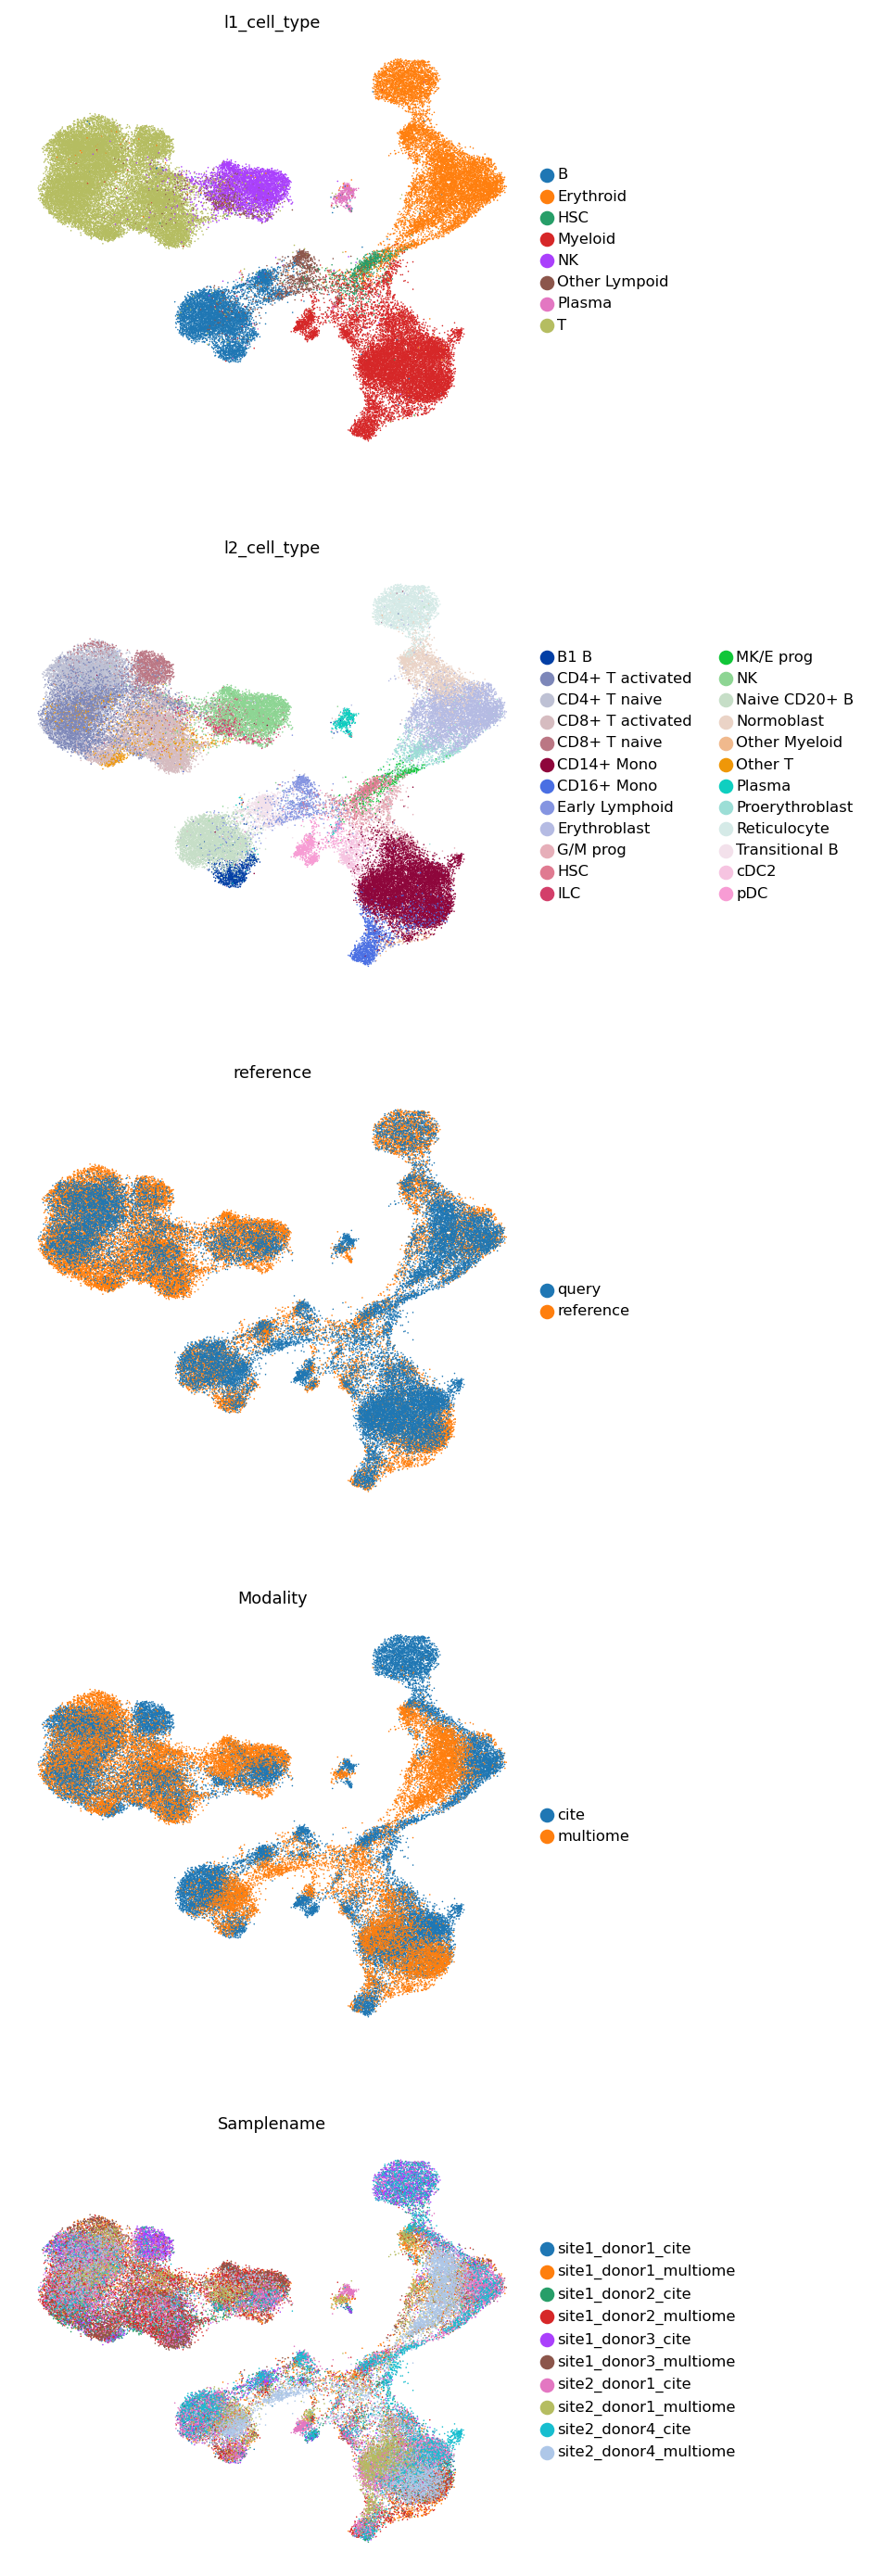

In [32]:
sc.pl.umap(adata_both, color=['l1_cell_type', 'l2_cell_type', 'reference', 'Modality', 'Samplename'], ncols=1, frameon=False)

We also can take a look at separate multimodal and unimodal queries.

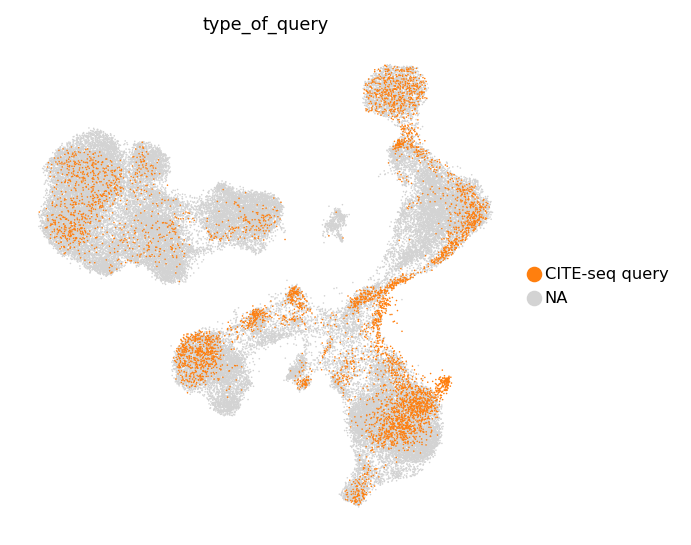

In [33]:
sc.pl.umap(
    adata_both,
    color='type_of_query', 
    ncols=1,
    frameon=False,
    groups=['CITE-seq query']
)

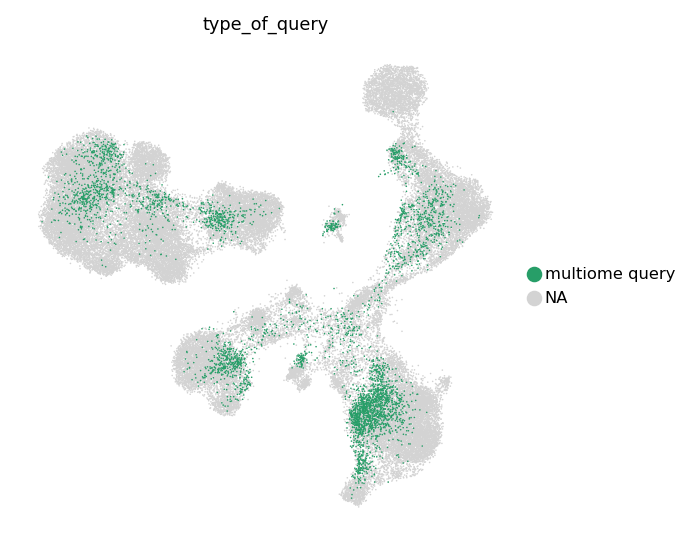

In [34]:
sc.pl.umap(
    adata_both,
    color='type_of_query', 
    ncols=1,
    frameon=False,
    groups=['multiome query']
)

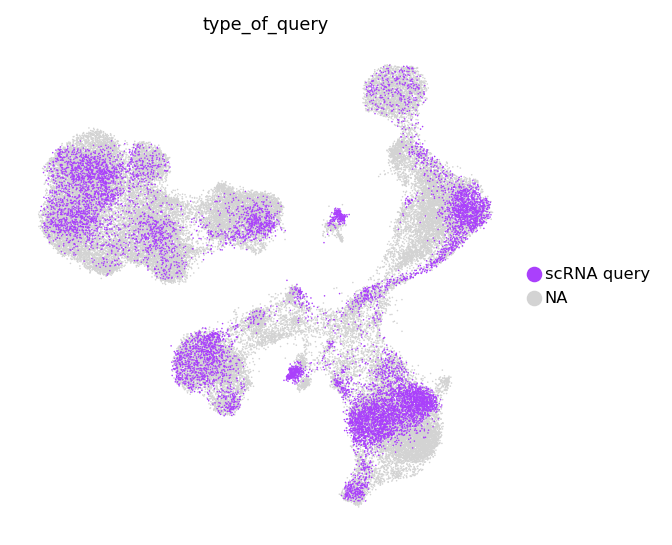

In [35]:
sc.pl.umap(
    adata_both,
    color='type_of_query', 
    ncols=1,
    frameon=False,
    groups=['scRNA query']
)

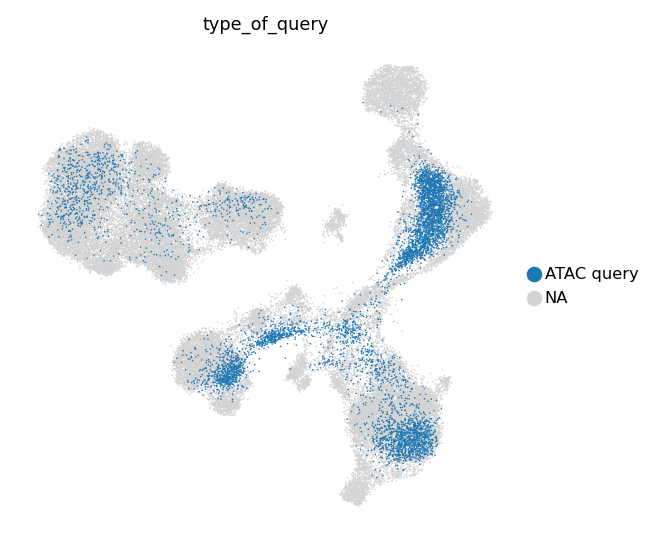

In [36]:
sc.pl.umap(
    adata_both,
    color='type_of_query', 
    ncols=1,
    frameon=False,
    groups=['ATAC query']
)